# Machine Learning Exercises: Chapter 7.5-7.6

See http://www.astroml.org/book_figures/chapter7/index.html

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import ticker

from sklearn import manifold, datasets, decomposition

## Nonlinear Features in Data


**Problem:** There are often well-defined structures in your data set that are non-linear. The classic example of this is the projection of a 2D surface into 3 dimensions in a curve (S).


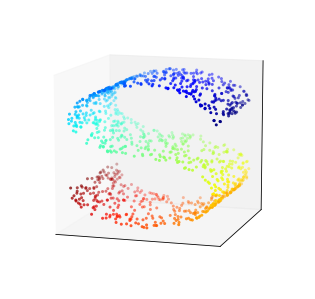

In [2]:
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# generate the S-curve dataset
np.random.seed(0)

n_points = 1100
out_dim = 2

X, color = datasets.samples_generator.make_s_curve(n_points)

# change the proportions to emphasize the weakness of PCA
X[:, 1] -= 1
X[:, 1] *= 1.5
X[:, 2] *= 0.5

#------------------------------------------------------------
# plot the 3D dataset
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.05, right=0.95,
                    bottom=0.05, top=0.9)

# matplotlib 1.0+ has a toolkit for generating 3D plots
from mpl_toolkits.mplot3d import Axes3D
ax1 = fig.add_subplot(221, projection='3d',
                          xticks=[], yticks=[], zticks=[])
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=color,
                cmap=plt.cm.jet, s=9, lw=0)
ax1.view_init(11, -73)

plt.show()



A PCA projection does not work well. The projection makes points that are topologically distant appear close together.

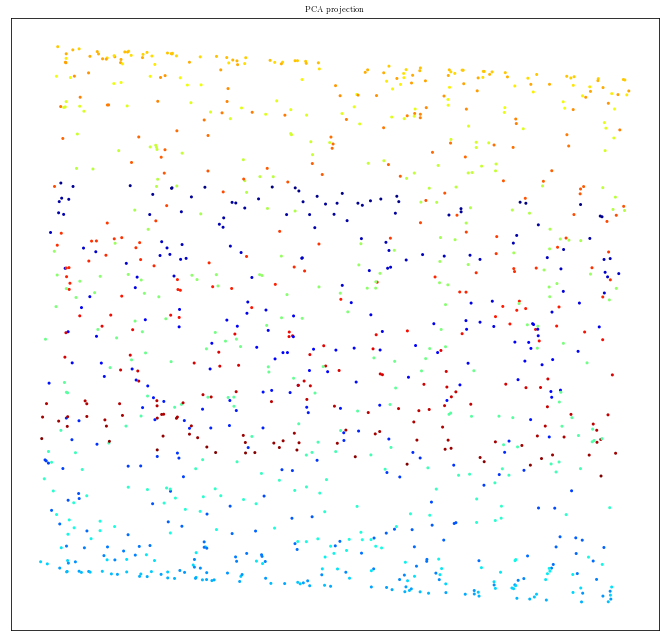

In [3]:
pca = decomposition.PCA(out_dim)
Y_pca = pca.fit_transform(X)

title = 'PCA projection'
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.05, right=0.95,
                    bottom=0.05, top=0.9)

ax=fig.add_subplot(111)
ax.scatter(Y_pca[:, 0], Y_pca[:, 1], c=color, cmap=plt.cm.jet, s=9, lw=0)
ax.set_title(title)
ax.set_xticks([])
ax.set_yticks([])
    
plt.show()


## Local Linear Embedding (LLE)

Attempts to preserve only local geometry. 

1. For each point, find (hyper)plane that is best described by only it's k nearest neighbors. 
2. Minimize |X - W X|^2, where X is a matrix of K dimensional row vectors (your data, i.e. x_i).
    > But require diagonals of W to be zero (that is, W_ii=0) and W_ij = 0 for all j is that not within the k nearest neighbors of i. 
3. Then minimize |Y - W Y|^2 with fixed W. Y will reflect the properties of the local neighborhoods found by W in X. 

**Test** Play around with n_neighbors below. An effective decomposition requires you know the density of your data relative to the distance between neighboring disconnecting regions. 


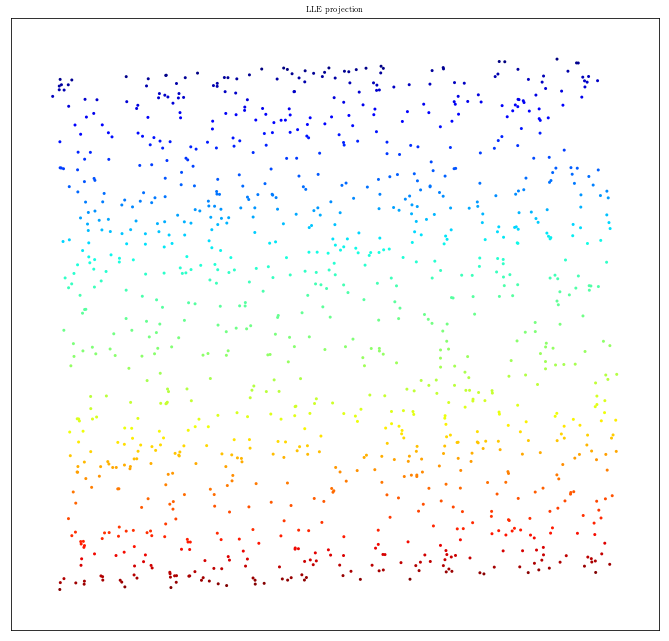

In [6]:
n_neighbors = 10

lle = manifold.LocallyLinearEmbedding(n_neighbors, out_dim, method='modified')
Y_lle = lle.fit_transform(X)


title = 'LLE projection'
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.05, right=0.95,
                    bottom=0.05, top=0.9)

ax=fig.add_subplot(111)
ax.scatter(Y_lle[:, 0], Y_lle[:, 1], c=color, cmap=plt.cm.jet, s=9, lw=0)
ax.set_title(title)
ax.set_xticks([])
ax.set_yticks([])
    
plt.show()


**Example:** Galaxy classification

This example uses 4,000 galaxies of 5 types, each with 1,000-dimensional data (spectra).
This example projects 1,000 dimensions into 3 (instead of 3 into 2 as above). 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import manifold, neighbors

from astroML.datasets import sdss_corrected_spectra
from astroML.datasets import fetch_sdss_corrected_spectra
from astroML.plotting.tools import discretize_cmap
from astroML.decorators import pickle_results

In [2]:
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Set up color-map properties
clim = (1.5, 6.5)
cmap = discretize_cmap(plt.cm.jet, 5)
cdict = ['unknown', 'star', 'absorption galaxy',
         'galaxy', 'emission galaxy',
         'narrow-line QSO', 'broad-line QSO']
cticks = [2, 3, 4, 5, 6]
formatter = plt.FuncFormatter(lambda t, *args: cdict[int(np.round(t))])


#------------------------------------------------------------
# Fetch the data; PCA coefficients have been pre-computed
data = fetch_sdss_corrected_spectra()

## ^ If this command doesn't work, put the "spec4000.npz" file directly in your astroML data folder 
##     (usually located at ~/astroML_data)


@pickle_results: using precomputed results from 'spec_LLE.pkl'


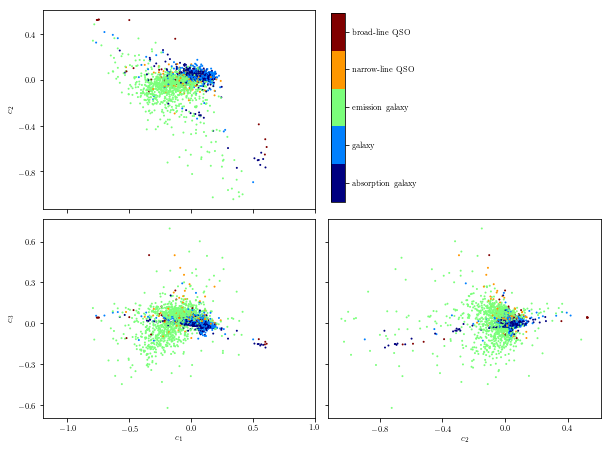

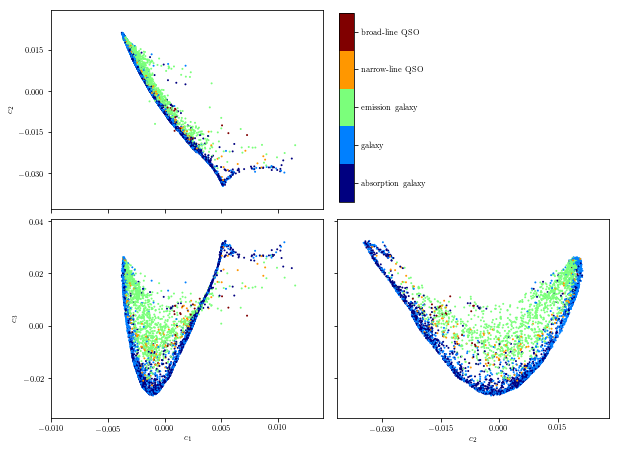

In [3]:
## This might take a little bit...

coeffs_PCA = data['coeffs']
c_PCA = data['lineindex_cln']
spec = sdss_corrected_spectra.reconstruct_spectra(data)
color = data['lineindex_cln']


#------------------------------------------------------------
# Compute the LLE projection; save the results
@pickle_results("spec_LLE.pkl")
def compute_spec_LLE(n_neighbors=10, out_dim=3):
    # Compute the LLE projection
    LLE = manifold.LocallyLinearEmbedding(n_neighbors, out_dim,
                                          method='modified',
                                          eigen_solver='dense')
    Y_LLE = LLE.fit_transform(spec)
    print " - finished LLE projection"

    # remove outliers for the plot
    BT = neighbors.BallTree(Y_LLE)
    dist, ind = BT.query(Y_LLE, n_neighbors)
    dist_to_n = dist[:, -1]
    dist_to_n -= dist_to_n.mean()
    std = np.std(dist_to_n)
    flag = (dist_to_n > 0.25 * std)
    print " - removing %i outliers for plot" % flag.sum()

    return Y_LLE[~flag], color[~flag]

coeffs_LLE, c_LLE = compute_spec_LLE(10, 3)


#----------------------------------------------------------------------
# Plot the results:
for (c, coeffs, xlim) in zip([c_PCA, c_LLE],
                             [coeffs_PCA, coeffs_LLE],
                             [(-1.2, 1.0), (-0.01, 0.014)]):
    fig = plt.figure(figsize=(10, 7.5))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    # axes for colorbar
    cax = plt.axes([0.525, 0.525, 0.02, 0.35])

    # Create scatter-plots
    scatter_kwargs = dict(s=4, lw=0, edgecolors='none', c=c, cmap=cmap)

    ax1 = plt.subplot(221)
    im1 = ax1.scatter(coeffs[:, 0], coeffs[:, 1], **scatter_kwargs)
    im1.set_clim(clim)
    ax1.set_ylabel('$c_2$')

    ax2 = plt.subplot(223)
    im2 = ax2.scatter(coeffs[:, 0], coeffs[:, 2], **scatter_kwargs)
    im2.set_clim(clim)
    ax2.set_xlabel('$c_1$')
    ax2.set_ylabel('$c_3$')

    ax3 = plt.subplot(224)
    im3 = ax3.scatter(coeffs[:, 1], coeffs[:, 2], **scatter_kwargs)
    im3.set_clim(clim)
    ax3.set_xlabel('$c_2$')

    fig.colorbar(im3, ax=ax3, cax=cax,
                 ticks=cticks,
                 format=formatter)

    ax1.xaxis.set_major_formatter(plt.NullFormatter())
    ax3.yaxis.set_major_formatter(plt.NullFormatter())

    ax1.set_xlim(xlim)
    ax2.set_xlim(xlim)

    for ax in (ax1, ax2, ax3):
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.show()

Can try to project in 2 dimensions - but it doesn't work as well

@pickle_results: using precomputed results from 'spec_LLE2.pkl'


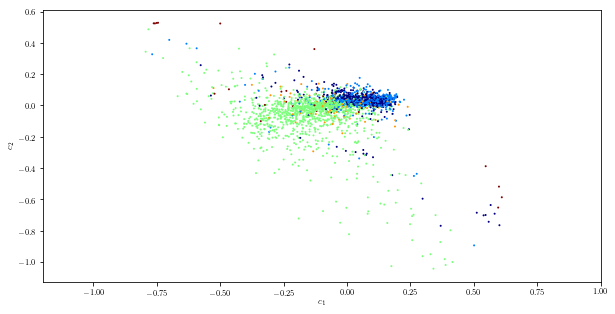

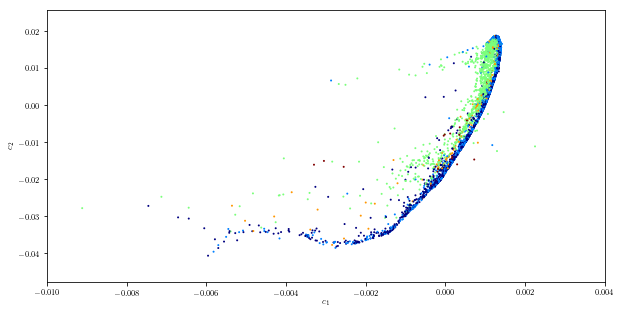

In [4]:
coeffs_PCA = data['coeffs']
c_PCA = data['lineindex_cln']
spec = sdss_corrected_spectra.reconstruct_spectra(data)
color = data['lineindex_cln']


#------------------------------------------------------------
# Compute the LLE projection; save the results
@pickle_results("spec_LLE2.pkl")
def compute_spec_LLE(n_neighbors=6, out_dim=2):
    # Compute the LLE projection
    LLE = manifold.LocallyLinearEmbedding(n_neighbors, out_dim,
                                          method='modified',
                                          eigen_solver='dense')
    Y_LLE = LLE.fit_transform(spec)
    print " - finished LLE projection"

    # remove outliers for the plot
    BT = neighbors.BallTree(Y_LLE)
    dist, ind = BT.query(Y_LLE, n_neighbors)
    dist_to_n = dist[:, -1]
    dist_to_n -= dist_to_n.mean()
    std = np.std(dist_to_n)
    flag = (dist_to_n > 0.25 * std)
    print " - removing %i outliers for plot" % flag.sum()

    return Y_LLE[~flag], color[~flag]

coeffs_LLE, c_LLE = compute_spec_LLE(10, 2)


#----------------------------------------------------------------------
# Plot the results:
for (c, coeffs, xlim) in zip([c_PCA, c_LLE],
                             [coeffs_PCA, coeffs_LLE],
                             [(-1.2, 1.0), (-0.01, 0.004)]):
    fig = plt.figure(figsize=(10, 5))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    # axes for colorbar
    cax = plt.axes([0.525, 0.525, 0.02, 0.35])

    # Create scatter-plots
    scatter_kwargs = dict(s=4, lw=0, edgecolors='none', c=c, cmap=cmap)

    ax2 = plt.subplot(111)
    im2 = ax2.scatter(coeffs[:, 0], coeffs[:, 1], **scatter_kwargs)
    im2.set_clim(clim)
    ax2.set_xlabel('$c_1$')
    ax2.set_ylabel('$c_2$')

    ax2.set_xlim(xlim)
    

plt.show()

## Isometric Mapping (IsoMap)

Given: N x K matrix X of data

1. Create connected graph G, representing data where Gij is the distance if i and j are nearest neighbors and 0 otherwise
2. Construct Distance Matrix D, such that Dij is the distance between points i and j, traversing the graph G. 
    > This is as opposed to a more conventional distance matrix R, where Rij is the Euclidean distance between
    > points i and j. It therefore may more easily follow complex, non-linear shapes.  
3. Given the Distance Matrix D, apply multidemensional scaling framwork (MDS). MDS attempts to reconstruct locations of data based on a set of distances between the data.
    > Find new data set Y that minimizes |f(D_X) - f(D_Y)|^2
    > where f(M) = ( I/N  M^2  I/N ) / 2 
    > which results in d-dimensional embedding Y equal to the top d eigenvectors of f(D_X).
    > That is you search for the most important (non-linear) directions which preserve distances between points


@pickle_results: using precomputed results from 'spec_ISO.pkl'


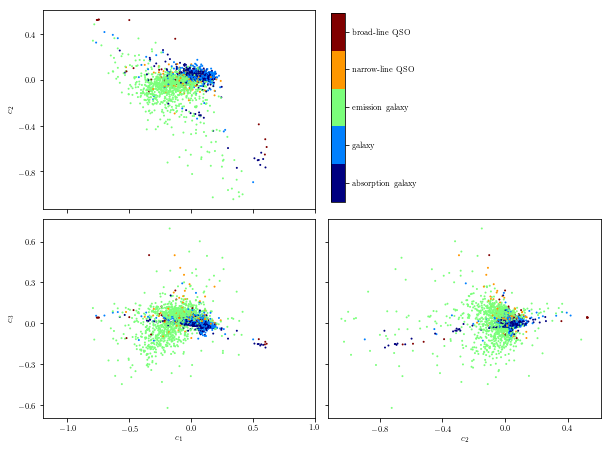

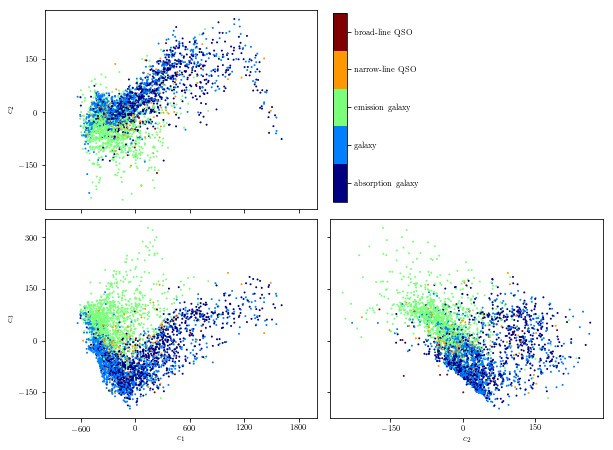

In [13]:
## This might take a little bit...

##from sklearn.manifold import Isomap

coeffs_PCA = data['coeffs']
c_PCA = data['lineindex_cln']
spec = sdss_corrected_spectra.reconstruct_spectra(data)
color = data['lineindex_cln']


#------------------------------------------------------------
# Compute the ISO projection; save the results
@pickle_results("spec_ISO.pkl")
def compute_spec_ISO(n_neighbors=10, out_dim=3):
    # Compute the ISO projection
    ISO = manifold.Isomap(n_neighbors, out_dim)

    Y_ISO = ISO.fit_transform(spec)
    print " - finished ISO projection"

    # remove outliers for the plot
    BT = neighbors.BallTree(Y_ISO)
    dist, ind = BT.query(Y_ISO, n_neighbors)
    dist_to_n = dist[:, -1]
    dist_to_n -= dist_to_n.mean()
    std = np.std(dist_to_n)
    flag = (dist_to_n > 0.25 * std)
    print " - removing %i outliers for plot" % flag.sum()

    return Y_ISO[~flag], color[~flag]

coeffs_ISO, c_ISO = compute_spec_ISO(10, 3)


#----------------------------------------------------------------------
# Plot the results:
for (c, coeffs, xlim) in zip([c_PCA, c_ISO],
                             [coeffs_PCA, coeffs_ISO],
                             [(-1.2, 1.0), (-1000, 2000)]):
    fig = plt.figure(figsize=(10, 7.5))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    # axes for colorbar
    cax = plt.axes([0.525, 0.525, 0.02, 0.35])

    # Create scatter-plots
    scatter_kwargs = dict(s=4, lw=0, edgecolors='none', c=c, cmap=cmap)

    ax1 = plt.subplot(221)
    im1 = ax1.scatter(coeffs[:, 0], coeffs[:, 1], **scatter_kwargs)
    im1.set_clim(clim)
    ax1.set_ylabel('$c_2$')

    ax2 = plt.subplot(223)
    im2 = ax2.scatter(coeffs[:, 0], coeffs[:, 2], **scatter_kwargs)
    im2.set_clim(clim)
    ax2.set_xlabel('$c_1$')
    ax2.set_ylabel('$c_3$')

    ax3 = plt.subplot(224)
    im3 = ax3.scatter(coeffs[:, 1], coeffs[:, 2], **scatter_kwargs)
    im3.set_clim(clim)
    ax3.set_xlabel('$c_2$')

    fig.colorbar(im3, ax=ax3, cax=cax,
                 ticks=cticks,
                 format=formatter)

    ax1.xaxis.set_major_formatter(plt.NullFormatter())
    ax3.yaxis.set_major_formatter(plt.NullFormatter())

    ax1.set_xlim(xlim)
    ax2.set_xlim(xlim)

    for ax in (ax1, ax2, ax3):
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.show()

## Manifold Learning Weaknesses

1. Gappy or missing data (even in a single dimension - e.g., missing Z value in S curve) causes significant problems
2. There exists no recommendation in the literature for choosing k, except trial and error
3. The output dimensions is a free parameter. People usually choose d = 2 or 3 because it is easy to plot - but this
    may be incorrect or d may change in different areas
4. Sensitivity to outliers and data density. Bad points may "short circuit" manifold connections. 
5. One can not uniquely reproduce the manifold from the projection - need entire data set and projections
    > Can not technically cross-validate the model (k value)! Must retrain with all data and compare. 

## Independent Component Analysis (ICA)

Goal: Use idea of statistical independence to isolate (unmix) individual signals that are stacked to create observed signal
    -> E.g., a galaxy is a sum of individual stars and gas clouds, which each individually look identical between
    different galaxies
Try to find mixing amplitudes of each individual object's spectrum which create each galaxy. 

Method:
1. The spectrum of the i-th galaxy x_i has form
    > x_i = a1_i s1 + a2_i s2 + a3_i s3 + ....
    > where s1 is the spectrum of a star of type 1, etc. and a_j is the amplitude of each s_j
2. Assume each star type emits independently of each other star. That is s1 is independent of s2, s3, etc. 
3. If two variables (stellar spectra) are truly independent, than their sum will be more Gaussian than their individual distributions (due to Central Limit Theorem).
    > Attempt to identify "Unmixing Matrix" W that maximizes non-Gaussianity of individual random variables (spectra)
    > Can use Kurtosis, -(Entropy), etc. 
    
See Fig. 7.4
    
Challenges:
Must choose number of independent contributors in data set
Asumption that each component is uncorrelated may be false
Computational Hard - often use PCA first to reduce dimensionality, then run ICA


